# PyTorch Lightning Tutorial: CIFAR-10 Classification

## Overview

This tutorial introduces **PyTorch Lightning**, a lightweight wrapper around PyTorch that eliminates boilerplate code while maintaining full flexibility. We'll build a complete image classification pipeline using CIFAR-10, demonstrating Lightning's core features and best practices.

### Learning Objectives

By the end of this tutorial, you will:

- ✅ Understand the benefits of PyTorch Lightning over pure PyTorch
- ✅ Organize data handling with `LightningDataModule`
- ✅ Build models using `LightningModule` with integrated metrics
- ✅ Configure training with `Trainer` and essential callbacks
- ✅ Track experiments using TensorBoard
- ✅ Evaluate and export models for deployment

### Dataset

**CIFAR-10** consists of 60,000 32×32 color images in 10 classes:

- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- 50,000 training images, 10,000 test images
- We'll split training into 45,000 train / 5,000 validation


## Section 1: 🚀 Introduction & Setup

### What is PyTorch Lightning?

PyTorch Lightning is a lightweight wrapper around PyTorch that:

- ✅ **Reduces boilerplate** by 60-90% (training loops, device handling, logging)
- ✅ **Enforces best practices** automatically (gradient management, optimization)
- ✅ **Makes code more readable** and maintainable (organized structure)
- ✅ **Enables easy scaling** to multi-GPU/TPU with minimal code changes

### Pure PyTorch vs PyTorch Lightning

| Feature             | Pure PyTorch          | PyTorch Lightning           |
| ------------------- | --------------------- | --------------------------- |
| **Training Loop**   | Manual (~50+ lines)   | Automatic (0 lines)         |
| **Device Handling** | Manual `.to(device)`  | Automatic                   |
| **Logging**         | Manual tracking       | Built-in logger integration |
| **Multi-GPU**       | Complex setup         | Single `devices` parameter  |
| **Checkpointing**   | Custom implementation | Automatic with callbacks    |
| **Early Stopping**  | Custom logic          | EarlyStopping callback      |
| **Code Lines**      | ~500 lines            | ~200 lines                  |

### When to Use PyTorch Lightning

**✅ Use Lightning When:**

- Building production ML systems
- Running multiple experiments
- Need multi-GPU training
- Working in teams (standardized structure)

**❌ Skip Lightning When:**

- Learning PyTorch basics
- Highly custom training loops
- Simple one-off scripts


In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# Computer Vision
import torchvision
from torchvision import transforms, datasets
import torchmetrics

# Utilities
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional
from tqdm.auto import tqdm

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Device detection and setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")
else:
    print("GPU not available. Training will be slower on CPU.")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
Memory Allocated: 24.00 GB


In [3]:
# Set random seed for reproducibility
def set_seed(seed: int = 42):
    """
    Set random seed for reproducibility across various libraries.

    Args:
        seed (int): The seed value to set. Default is 42.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed)

set_seed(42)
print("✅ Random seed set for reproducibility.")

Seed set to 42


✅ Random seed set for reproducibility.


In [4]:
# Create directories for saving models and logs
DIRECTORIES = ["data", "lightning_logs", "checkpoints"]

for directory in DIRECTORIES:
    Path(directory).mkdir(parents=True, exist_ok=True)
    print(f"✅ Directory '{directory}' is ready.")

print("✅ Environment setup complete!")

✅ Directory 'data' is ready.
✅ Directory 'lightning_logs' is ready.
✅ Directory 'checkpoints' is ready.
✅ Environment setup complete!


## Section 2: 📊 Data Preparation with LightningDataModule

### What is LightningDataModule?

`LightningDataModule` is a reusable, shareable class that encapsulates all data-related code:

- **Data downloading** (`prepare_data`)
- **Data preprocessing** (`setup`)
- **DataLoader creation** (`train/val/test_dataloader`)

### Benefits

1. **Organized**: All data logic in one place
2. **Reusable**: Share across projects and teams
3. **Multi-GPU safe**: `prepare_data()` called once, `setup()` on each GPU
4. **Clean separation**: Data handling separate from model logic

### CIFAR-10 Normalization

We use the standard CIFAR-10 normalization values:

- **Mean**: `(0.4914, 0.4822, 0.4465)`
- **Std**: `(0.2470, 0.2435, 0.2616)`

These values are computed from the entire training set and help neural networks converge faster.


In [5]:
class CIFAR10DataModule(pl.LightningDataModule):
    """
    Lightning DataModule for CIFAR-10 dataset.

    Handles data downloading, preprocessing, and loading.
    Splits data: 45K train, 5K val, 10K test.

    Args:
        data_dir (str): Directory to store the dataset.
        batch_size (int): Batch size for DataLoader.
        num_workers (int): Number of workers for DataLoader.
    """

    def __init__(
            self,
            data_dir: str = "./data",
            batch_size: int = 128,
            num_workers: int = 4,
    ):
        super().__init__()

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # CIFAR-10 specific normalization (computed from training set)
        self.mean = [0.4914, 0.4822, 0.4465]
        self.std = (0.2470, 0.2435, 0.2616)

        # Training transforms include data augmentation
        self.train_transforms = transforms.Compose([
            transforms.RandomCrop(32, padding=4), # Random crop with padding
            transforms.RandomHorizontalFlip(p=0.5),    # Random horizontal flip with probability 0.5
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

        # Test transforms (no augmentation)
        self.test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

    def prepare_data(self):
        """
        Download data (called once, on single GPU).

        This method is called only on 1 GPU in distributed training.
        Use it to download data, but NOT to assign state (use setup() for that).
        """
        # Download CIFAR-10 dataset
        datasets.CIFAR10(root=self.data_dir, train=True, download=True)
        datasets.CIFAR10(root=self.data_dir, train=False, download=True)
        print("✅ CIFAR-10 dataset downloaded.")

    def setup(self, stage: Optional[str] = None):
        """
        Setup datasets for each stage.

        Called on every GPU in distributed training.
        Assigns state (self.train_dataset, etc.).

        Args:
            stage: 'fit', 'test', or None (for all stages)
        """
        # Training and validation datasets
        if stage == 'fit' or stage is None:
            cifar_full = datasets.CIFAR10(
                root=self.data_dir, 
                train=True, 
                transform=self.train_transforms
            )

            # Split into train (45K) and val (5K)
            self.cifar_train, self.cifar_val = random_split(
                cifar_full, 
                [45000, 5000],
                generator=torch.Generator().manual_seed(42)  # For reproducibility
            )

            # Use test transforms for validation set (no augmentation)
            self.cifar_val.dataset = datasets.CIFAR10(
                root=self.data_dir, 
                train=True, 
                transform=self.test_transforms
            )

            print("✅ Training and validation datasets are ready.")
        
        # Test dataset
        if stage == 'test' or stage is None:
            self.cifar_test = datasets.CIFAR10(
                root=self.data_dir, 
                train=False, 
                transform=self.test_transforms
            )
            print("✅ Test dataset is ready.")
    
    def train_dataloader(self):
        """Return training DataLoader."""
        return DataLoader(
            self.cifar_train, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        """Return validation DataLoader."""
        return DataLoader(
            self.cifar_val, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        """Return test DataLoader."""
        return DataLoader(
            self.cifar_test, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
            pin_memory=True
        )

print("✅ CIFAR10DataModule class defined successfully.")

✅ CIFAR10DataModule class defined successfully.


In [6]:
# Instantiate the data module
data_module = CIFAR10DataModule(data_dir="./data", 
                                batch_size=128, 
                                num_workers=4
                                )

# Prepare data (download if necessary)
data_module.prepare_data()
print("✅ Data preparation complete.")

# Setup datasets
data_module.setup()
print("✅ Data setup complete.")

✅ CIFAR-10 dataset downloaded.
✅ Data preparation complete.
✅ Training and validation datasets are ready.
✅ Test dataset is ready.
✅ Data setup complete.


In [7]:
# Verify dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

print("Dataset Statistics:")
print(f"  Training samples: {len(data_module.cifar_train):,}")
print(f"  Validation samples: {len(data_module.cifar_val):,}")
print(f"  Test samples: {len(data_module.cifar_test):,}")

print("\nDataLoader Configuration:")
print(f"  Batch size: {data_module.batch_size}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Dataset Statistics:
  Training samples: 45,000
  Validation samples: 5,000
  Test samples: 10,000

DataLoader Configuration:
  Batch size: 128
  Training batches: 352
  Validation batches: 40
  Test batches: 79


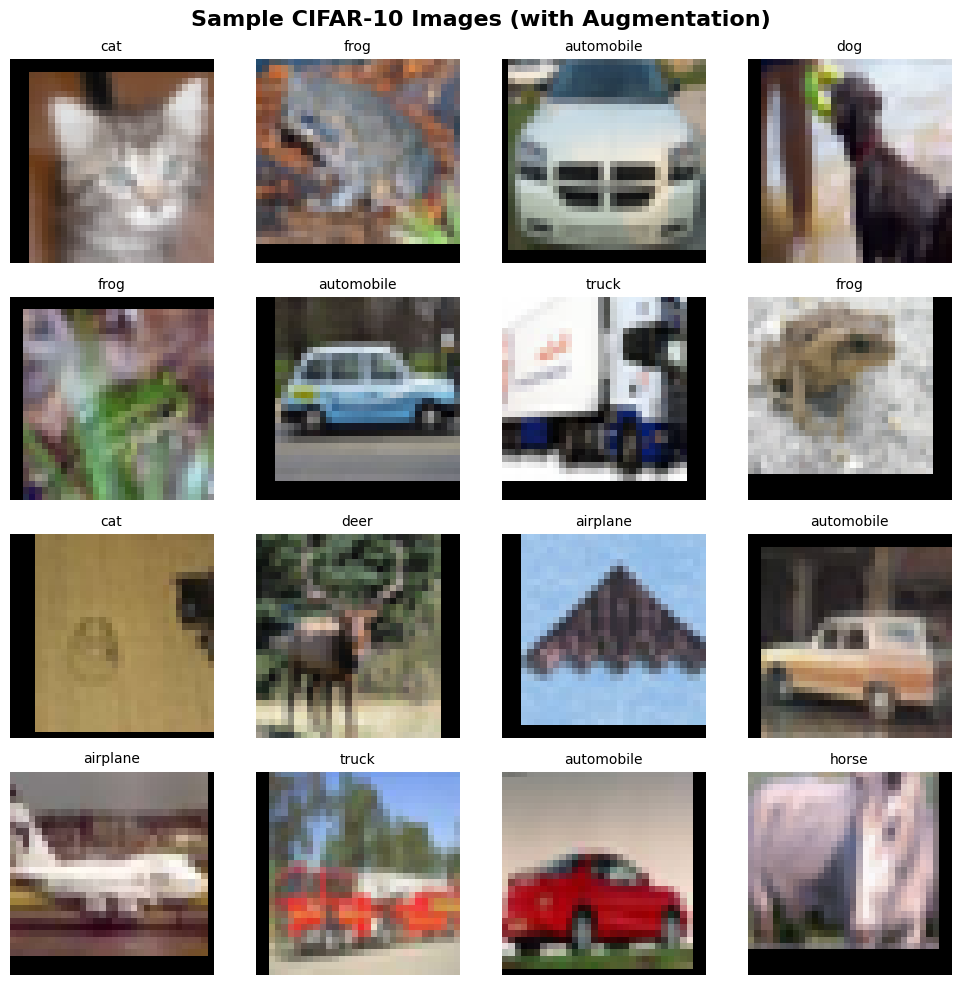

In [8]:
# Visualize sample images
class_names = data_module.cifar_train.dataset.classes

# Get a batch of training data
images, labels = next(iter(train_loader))

# Denormalize images for visualization
def denormalize(tensor: torch.Tensor, mean: list, std: list) -> torch.Tensor:
    """Denormalize a tensor image for visualization."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Plot 16 sample images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Sample CIFAR-10 Images (with Augmentation)', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    # Denormalize the image
    img = denormalize(images[idx].clone(), 
                      data_module.mean, 
                      data_module.std
                      )

    # Convert to numpy and transpose
    img = img.numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] for display

    ax.imshow(img)
    ax.set_title(class_names[labels[idx]], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Section 3: 🏗️ Model Architecture with LightningModule

### What is LightningModule?

`LightningModule` is the core Lightning abstraction. It organizes your PyTorch code into these methods:

- **`__init__`**: Define model architecture and hyperparameters
- **`forward`**: Define forward pass (inference)
- **`training_step`**: Define what happens in one training step
- **`validation_step`**: Define what happens in one validation step
- **`test_step`**: Define what happens in one test step
- **`configure_optimizers`**: Define optimizer(s) and scheduler(s)

### Key Features

1. **`self.save_hyperparameters()`**: Automatically saves all hyperparameters for checkpointing
2. **`self.log()`**: Logs metrics to TensorBoard and progress bar
3. **torchmetrics integration**: Automatic device handling for metrics
4. **Automatic device placement**: No need for manual `.to(device)`

### Architecture Overview

Our SimpleCNN consists of:

- **3 Convolutional Blocks**: 64 → 128 → 256 channels
- **Batch Normalization**: Stabilizes training
- **MaxPooling**: Reduces spatial dimensions
- **Dropout**: Prevents overfitting
- **Fully Connected Classifier**: 256×4×4 → 512 → 10 classes


In [9]:
class SimpleCNN(pl.LightningModule):
    """
    SimpleCNN for CIFAR-10 classification using PyTorch Lightning.

    Architecture:
    - 3 convolutional blocks (64 -> 128 -> 256 channels)
    - Batch normalization for stable training
    - Dropout for regularization
    - Fully connected layer for classification

    Args:
        num_classes (int): Number of output classes. Default is 10 for CIFAR-10.
        learning_rate (float): Learning rate for optimizer. Default is 1e-3.
        dropout_rate (float): Dropout rate for regularization. Default is 0.5.
    """

    def __init__(
            self,
            num_classes: int = 10,
            learning_rate: float = 1e-3,
            dropout_rate: float = 0.5,
    ):
        super().__init__()
        # Save hyperparameters (accessible via self.hparams)
        # This makes them available for logging and checkpointing
        self.save_hyperparameters()

        # Convolutional block 1: 3 -> 64 channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block 2: 64 -> 128 channels
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block 3: 128 -> 256 channels
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Metrics (torchmetrics automatically handles device placement)
        self.train_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
        self.val_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
        self.test_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, 32, 32)
        
        Returns:
            Logits of shape (batch_size, num_classes)
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.classifier(x)
        return x # Could also be written like this -> self.classifier(self.conv3(self.conv2(self.conv1(x))))
    
    def training_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        """
        Training step for a single batch.

        Lightning calls this for each training batch.

        Args:
            batch (tuple): A batch of data (images, labels).
            batch_idx (int): Index of the batch.
        
        Returns:
            Loss value (Lightning handles backward pass).
        """
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)

        # Log metrics (automatically sent to logger)
        # on_step=False: don't log every step, only epoch end
        # on_epoch=True: log at epoch average
        # prog_bar=True: show in progress bar
        self.log('train_loss',
                 loss, 
                 on_step=False, 
                 on_epoch=True, 
                 prog_bar=True
                 )
        self.log('train_acc',
                 self.train_acc,
                 on_step=False,
                 on_epoch=True,
                 prog_bar=True
                 )
        
        return loss
    
    def validation_step(self, batch: tuple, batch_idx: int):
        """
        Validation step for a single batch.

        Lightning calls this for each validation batch.

        Args:
            batch (tuple): A batch of data (images, labels).
            batch_idx (int): Index of the batch.
        """
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        self.val_acc.update(preds, y)

        # Log metrics
        self.log('val_loss',
                 loss,
                 on_step=False,
                 on_epoch=True,
                 prog_bar=True
                 )
        self.log('val_acc',
                 self.val_acc,
                 on_step=False,
                 on_epoch=True,
                 prog_bar=True
                 )
        
        return loss
    
    def test_step(self, batch: tuple, batch_idx: int):
        """
        Test step for a single batch.

        Lightning calls this for each test batch.

        Args:
            batch (tuple): A batch of data (images, labels).
            batch_idx (int): Index of the batch.
        """
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)

        # Log metrics
        self.log('test_loss',
                 loss,
                 on_step=False,
                 on_epoch=True,
                 prog_bar=True
                 )
        self.log('test_acc',
                 self.test_acc,
                 on_step=False,
                 on_epoch=True,
                 prog_bar=True
                 )
        
        return loss
    
    def configure_optimizers(self):
        """
        Configure optimizer and learning rate scheduler.

        Lightning calls this to set up training optimization.

        Returns:
            dict: Dictionary containing optimizer and scheduler.
        """
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.hparams.learning_rate,
            weight_decay=1e-4 # L2 regularization
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',     # Minimize validation loss
            factor=0.5,     # Reduce LR by 50%
            patience=3,     # Wait for 3 epochs before reducing
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",  # Monitor validation loss for scheduler
                "frequency": 1          # Check every epoch
            }
        }

print("✅ SimpleCNN class defined successfully.")

✅ SimpleCNN class defined successfully.


In [10]:
# Instantiate the model
model = SimpleCNN(
    num_classes=10,
    learning_rate=1e-3,
    dropout_rate=0.5
)

print("Model architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model architecture:
SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [11]:
# Test forward pass with dummy data
dummy_input = torch.randn(4, 3, 32, 32)  # Batch of 4 images
model.eval()

with torch.no_grad():
    dummy_output = model(dummy_input)

print("Forward Pass Test:")
print(f"  Input shape: {dummy_input.shape}")
print(f"  Output shape: {dummy_output.shape}")
print(f"  Output logits (first sample): {dummy_output[0]}")
print(f"\n✅ Model forward pass successful")

Forward Pass Test:
  Input shape: torch.Size([4, 3, 32, 32])
  Output shape: torch.Size([4, 10])
  Output logits (first sample): tensor([-0.0464, -0.0094, -0.0451, -0.0419, -0.0795,  0.0392,  0.0084, -0.0512,
        -0.0606, -0.0118])

✅ Model forward pass successful


## Section 4:⚡Training with Lightning Trainer

### What is the Lightning Trainer?

The `Trainer` is Lightning's most powerful feature. It automates:
- Training loops (forward, backward, optimization)
- Validation loops
- Epoch management
- Device handling (CPU/GPU/TPU)
- Distributed training
- Gradient accumulation
- Mixed precision training

### Essential Callbacks

Callbacks provide modular functionality:

1. **ModelCheckpoint**: Automatically saves best models
   - Monitors validation accuracy
   - Saves top-k checkpoints
   - Prevents losing progress

2. **EarlyStopping**: Stops training when validation stops improving
   - Prevents overfitting
   - Saves training time
   - Monitors validation loss

3. **LearningRateMonitor**: Tracks learning rate changes
   - Logs LR to TensorBoard
   - Useful for debugging schedulers

### Mixed Precision Training

Using `precision='16-mixed'`:
- **Faster training**: ~2-3x speedup on modern GPUs
- **Lower memory usage**: Allows larger batch sizes
- **Same accuracy**: Automatic loss scaling prevents underflow


In [12]:
# Configuration class for centralized settings
class Config:
    """Training configuration settings."""
    # Training
    MAX_EPOCHS = 30
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    DROPOUT_RATE = 0.5

    # Data
    DATA_DIR = "./data"
    NUM_WORKERS = 4

    # Logging and Checkpointing
    LOG_DIR = "./lightning_logs"
    CHECKPOINT_DIR = "./checkpoints"

    # Class names
    CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
print("✅ Config class defined successfully.")

✅ Config class defined successfully.


In [13]:
# Initialize components
data_module = CIFAR10DataModule(
    data_dir=Config.DATA_DIR,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS
)

model = SimpleCNN(
    num_classes=10,
    learning_rate=Config.LEARNING_RATE,
    dropout_rate=Config.DROPOUT_RATE
)

print("✅ Data module and model initialized")

✅ Data module and model initialized


In [14]:
# Setup callbacks

# 1. ModelCheckpoint: Save best models based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    dirpath=Config.CHECKPOINT_DIR,
    filename='cifar10-{epoch:02d}-{val_acc:.4f}',
    monitor='val_acc',      # Metric to monitor
    mode='max',             # Maximize validation accuracy
    save_top_k=3,           # Keep top 3 models
)

# 2. EarlyStopping: Stop training if validation loss doesn't improve
early_stop_callback = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5,             # Wait 5 epochs before stopping
    mode='min',             # Minimize validation loss
)

# 3. LearningRateMonitor: Track learning rate changes
lr_monitor = LearningRateMonitor(logging_interval='epoch')

print("✅ Callbacks configured:")
print("  - ModelCheckpoint (saves top 3 models by val_acc)")
print("  - EarlyStopping (patience=5 epochs on val_loss)")
print("  - LearningRateMonitor (logs LR changes)")

✅ Callbacks configured:
  - ModelCheckpoint (saves top 3 models by val_acc)
  - EarlyStopping (patience=5 epochs on val_loss)
  - LearningRateMonitor (logs LR changes)


In [15]:
# Setup TensorBoard logger
tensorboard_logger = TensorBoardLogger(
    save_dir=Config.LOG_DIR,
    name='cifar10_cnn',
    version='experiment_1'
)

print("✅ TensorBoard logger configured")
print(f"  Log directory: {tensorboard_logger.log_dir}")
print(f"\nTo view logs, run: tensorboard --logdir={Config.LOG_DIR}")

✅ TensorBoard logger configured
  Log directory: ./lightning_logs\cifar10_cnn\experiment_1

To view logs, run: tensorboard --logdir=./lightning_logs


In [16]:
# Create Lightning Trainer
trainer = pl.Trainer(
    max_epochs=Config.MAX_EPOCHS,
    accelerator='auto',              # Automatically use GPU if available
    devices=1,                       # Use 1 device (CPU or GPU)
    callbacks=[
        checkpoint_callback, 
        early_stop_callback, 
        lr_monitor
    ],
    logger=tensorboard_logger,
    log_every_n_steps=50,           # Log every 50 training steps
    deterministic=True,              # Reproducibility
    precision='16-mixed'             # Mixed precision training (faster)
)

print("✅ Trainer configured:")
print(f"  Max epochs: {trainer.max_epochs}")
print(f"  Accelerator: {trainer.accelerator}")
print(f"  Precision: {trainer.precision}")
print(f"  Callbacks: {len(trainer.callbacks)} registered")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


✅ Trainer configured:
  Max epochs: 30
  Accelerator: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x00000181D90E8D70>
  Precision: 16-mixed
  Callbacks: 5 registered


In [17]:
# Train the model (Lightning handles everything!)
print("Starting training...\n")

trainer.fit(model, data_module)

print("\n✅ Training complete!")

Starting training...


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



✅ CIFAR-10 dataset downloaded.


c:\Users\karlghosn\Desktop\TorchVisionLab\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory C:\Users\karlghosn\Desktop\TorchVisionLab\10_projects\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\karlghosn\Desktop\TorchVisionLab\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name       | Type               | Params | Mode  | FLOPs
------------------------------------------------------------------
0 | conv1      | Sequential         | 1.9 K  | train | 0    
1 | conv2      | Sequential         | 74.1 K | train | 0    
2 | conv3      | Sequential         | 295 K  | train | 0    
3 | classifier | Sequential         | 2.1 M  | train | 0    
4 | train_acc  | MulticlassAccuracy | 0      | train | 0    
5 | val_acc    | MulticlassAccur

✅ Training and validation datasets are ready.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\karlghosn\Desktop\TorchVisionLab\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\karlghosn\Desktop\TorchVisionLab\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.



✅ Training complete!


## Section 5: 📈 Evaluation & TensorBoard Visualization

### Model Evaluation

After training, we:

1. Load the best checkpoint (highest validation accuracy)
2. Evaluate on the test set
3. Generate predictions for all test samples
4. Visualize results with confusion matrix
5. Analyze per-class performance

### TensorBoard Integration

Lightning automatically logs:

- Loss curves (train and validation)
- Accuracy metrics
- Learning rate schedule
- Model hyperparameters

To view TensorBoard:

```bash
tensorboard --logdir=lightning_logs
```

Then open http://localhost:6006 in your browser.

### What to Look For

- **Scalars**: Loss and accuracy trends over epochs
- **LR Schedule**: Learning rate adjustments
- **Overfitting**: Gap between train and validation metrics
- **Convergence**: When metrics stabilize


In [18]:
# Test the model on test set
test_results = trainer.test(model, data_module)

print("\nTest Results:")
print(f"  Test Loss: {test_results[0]['test_loss']:.4f}")
print(f"  Test Accuracy: {test_results[0]['test_acc']:.4f}")

✅ CIFAR-10 dataset downloaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✅ Test dataset is ready.


c:\Users\karlghosn\Desktop\TorchVisionLab\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.864300012588501
        test_loss           0.40354686975479126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Test Results:
  Test Loss: 0.4035
  Test Accuracy: 0.8643


In [19]:
# Load best checkpoint
best_model_path = checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")

best_model = SimpleCNN.load_from_checkpoint(best_model_path)
best_model.eval()

print("✅ Best model loaded")

Loading best model from: C:\Users\karlghosn\Desktop\TorchVisionLab\10_projects\checkpoints\cifar10-epoch=29-val_acc=0.8662.ckpt
✅ Best model loaded


In [20]:
# Evaluate best model on test set
trainer_test = pl.Trainer(accelerator='auto', devices=1)
final_results = trainer_test.test(best_model, data_module)

print("\nFinal Test Results (Best Model):")
print(f"  Test Loss: {final_results[0]['test_loss']:.4f}")
print(f"  Test Accuracy: {final_results[0]['test_acc']:.4f}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


✅ CIFAR-10 dataset downloaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✅ Test dataset is ready.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8641999959945679
        test_loss           0.4035475552082062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final Test Results (Best Model):
  Test Loss: 0.4035
  Test Accuracy: 0.8642


In [21]:
# Generate predictions for all test samples
def get_all_predictions(model, datamodule):
    """Get predictions for all test samples.
    
    Args:
        model: Trained model
        datamodule: LightningDataModule
        
    Returns:
        Tuple of (predictions, true_labels)
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    test_loader = datamodule.test_dataloader()
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating predictions"):
            x, y = batch
            x = x.to(model.device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Generate predictions
preds, labels = get_all_predictions(best_model, data_module)

print(f"\n✅ Generated predictions for {len(preds)} test samples")

Generating predictions:   0%|          | 0/79 [00:15<?, ?it/s]


✅ Generated predictions for 10000 test samples


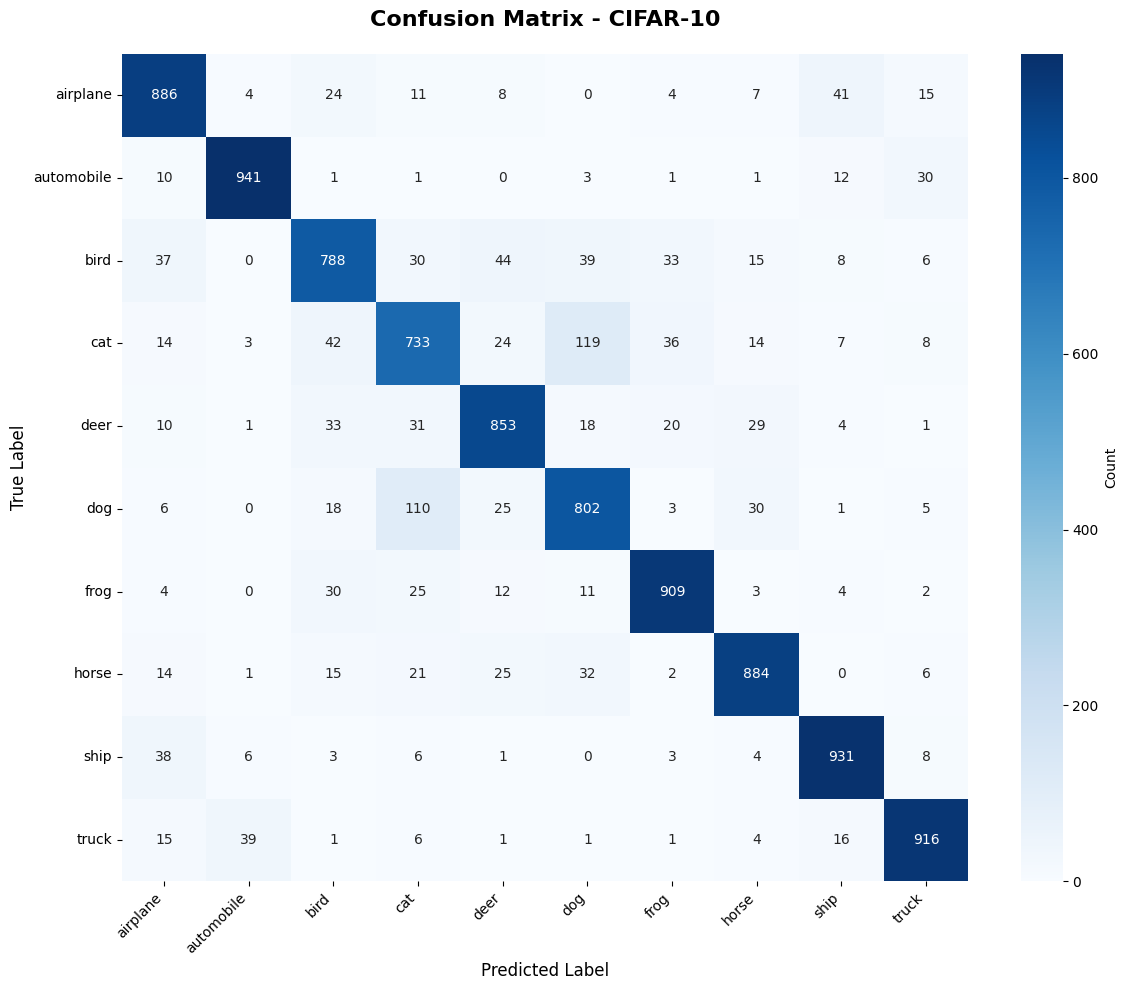


Confusion Matrix shows:
  - Diagonal elements: Correct predictions
  - Off-diagonal elements: Misclassifications


In [22]:
# Confusion matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=Config.CLASS_NAMES,
    yticklabels=Config.CLASS_NAMES,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - CIFAR-10', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix shows:")
print("  - Diagonal elements: Correct predictions")
print("  - Off-diagonal elements: Misclassifications")

In [23]:
# Classification report (per-class metrics)
print("\nClassification Report:")
print("=" * 70)
print(classification_report(
    labels, 
    preds, 
    target_names=Config.CLASS_NAMES,
    digits=4
))

# Overall accuracy
overall_acc = (preds == labels).mean()
print(f"\nOverall Test Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")


Classification Report:
              precision    recall  f1-score   support

    airplane     0.8569    0.8860    0.8712      1000
  automobile     0.9457    0.9410    0.9434      1000
        bird     0.8251    0.7880    0.8061      1000
         cat     0.7526    0.7330    0.7427      1000
        deer     0.8590    0.8530    0.8560      1000
         dog     0.7824    0.8020    0.7921      1000
        frog     0.8982    0.9090    0.9036      1000
       horse     0.8920    0.8840    0.8880      1000
        ship     0.9092    0.9310    0.9200      1000
       truck     0.9188    0.9160    0.9174      1000

    accuracy                         0.8643     10000
   macro avg     0.8640    0.8643    0.8640     10000
weighted avg     0.8640    0.8643    0.8640     10000


Overall Test Accuracy: 0.8643 (86.43%)


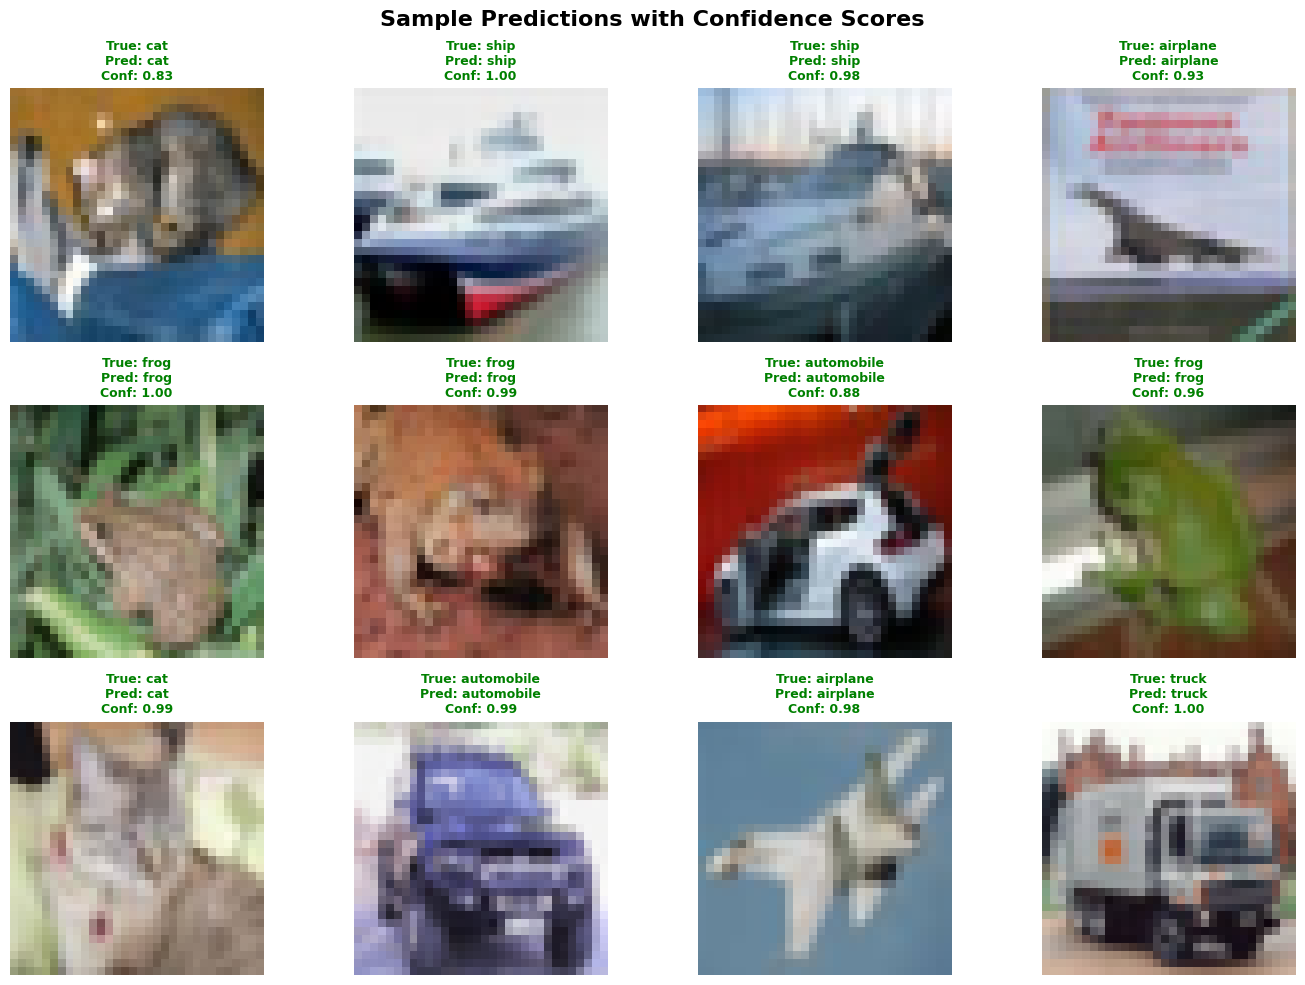

In [24]:
# Visualize sample predictions
def visualize_predictions(model, datamodule, class_names, num_samples=12):
    """Visualize sample predictions with confidence scores.
    
    Args:
        model: Trained model
        datamodule: LightningDataModule
        class_names: List of class names
        num_samples: Number of samples to visualize
    """
    model.eval()
    test_loader = datamodule.test_dataloader()
    
    # Get a batch
    images, true_labels = next(iter(test_loader))
    images = images[:num_samples]
    true_labels = true_labels[:num_samples]
    
    # Get predictions
    with torch.no_grad():
        logits = model(images.to(model.device))
        probs = F.softmax(logits, dim=1)
        confidences, pred_labels = torch.max(probs, dim=1)
    
    # Move to CPU for visualization
    pred_labels = pred_labels.cpu()
    confidences = confidences.cpu()
    
    # Plot
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    fig.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')
    
    for idx, ax in enumerate(axes.flat):
        # Denormalize image
        img = denormalize(
            images[idx].clone(),
            datamodule.mean,
            datamodule.std
        )
        img = img.numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)
        
        # Display image
        ax.imshow(img)
        
        # Create title with true and predicted labels
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        confidence = confidences[idx].item()
        
        # Color: green if correct, red if wrong
        color = 'green' if pred_labels[idx] == true_labels[idx] else 'red'
        
        title = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}"
        ax.set_title(title, fontsize=9, color=color, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, data_module, Config.CLASS_NAMES, num_samples=12)

### TensorBoard Access Instructions

To view detailed training metrics and visualizations:

1. **Open a terminal** in this directory

2. **Run TensorBoard**:

   ```bash
   tensorboard --logdir=lightning_logs
   ```

3. **Open browser** and navigate to:

   ```
   http://localhost:6006
   ```

4. **Explore the tabs**:
   - **Scalars**: Training/validation loss and accuracy curves
   - **Time Series**: Compare different experiments
   - **HP Params**: Hyperparameter tracking

### What to Look For:

- **Convergence**: Do metrics stabilize?
- **Overfitting**: Is there a gap between train and validation?
- **Learning Rate**: How does LR change over epochs?
- **Training Time**: Where are the bottlenecks?


## Section 6: 🎯 Advanced Features & Best Practices

### Custom Callbacks

Lightning's callback system is highly extensible. You can create custom callbacks for:
- Custom metric tracking
- Advanced logging
- Dynamic training modifications
- Alert systems

### ONNX Export

ONNX (Open Neural Network Exchange) enables:
- **Cross-platform deployment** (C++, Java, JavaScript)
- **Optimization** for production inference
- **Hardware acceleration** (ONNX Runtime)
- **Model sharing** across frameworks

### Production Best Practices

Lightning enforces production-ready patterns:
- Organized code structure
- Automatic checkpointing
- Experiment tracking
- Reproducible training
- Scalable to multiple GPUs


In [25]:
# Custom callback example
class MetricTracker(pl.Callback):
    """Custom callback to track and store metrics.
    
    Demonstrates how to create custom callbacks for specialized tasks.
    """
    
    def __init__(self):
        super().__init__()
        self.metrics = []
    
    def on_validation_epoch_end(self, trainer, pl_module):
        """Called at the end of validation epoch.
        
        Args:
            trainer: Lightning Trainer
            pl_module: LightningModule (our model)
        """
        val_loss = trainer.callback_metrics.get('val_loss')
        val_acc = trainer.callback_metrics.get('val_acc')
        
        if val_loss is not None and val_acc is not None:
            self.metrics.append({
                'epoch': trainer.current_epoch,
                'val_loss': val_loss.item(),
                'val_acc': val_acc.item()
            })
            
            # Custom logic: warn if performance drops significantly
            if trainer.current_epoch > 5 and val_acc < 0.4:
                print(f"\n⚠️  Warning: Low validation accuracy at epoch {trainer.current_epoch}")
                print(f"   Consider adjusting learning rate or checking data.")
    
    def get_metrics(self):
        """Return collected metrics."""
        return self.metrics

print("✅ Custom callback defined")
print("\nUse case: Track specific metrics, send alerts, save to database, etc.")

✅ Custom callback defined

Use case: Track specific metrics, send alerts, save to database, etc.


In [26]:
# Access saved hyperparameters
print("Model Hyperparameters:")
print("=" * 50)
for key, value in best_model.hparams.items():
    print(f"  {key}: {value}")

print("\nBenefit: Hyperparameters are saved with checkpoints.")
print("This ensures reproducibility and experiment tracking.")

Model Hyperparameters:
  num_classes: 10
  learning_rate: 0.001
  dropout_rate: 0.5

Benefit: Hyperparameters are saved with checkpoints.
This ensures reproducibility and experiment tracking.


In [28]:
# Export model to ONNX for deployment
best_model.eval()
best_model.to('cpu')  # ONNX export works best on CPU

# Create dummy input (batch_size=1, 3 channels, 32x32)
dummy_input = torch.randn(1, 3, 32, 32)

onnx_path = "cifar10_model.onnx"

# Export to ONNX
best_model.to_onnx(
    onnx_path,
    dummy_input,
    export_params=True,      # Include trained parameters
    opset_version=11,        # ONNX opset version
    input_names=['input'],   # Input tensor name
    output_names=['output'], # Output tensor name
    dynamic_axes={
        'input': {0: 'batch_size'},   # Variable batch size
        'output': {0: 'batch_size'}
    }
)

# Get file size
file_size = Path(onnx_path).stat().st_size / (1024 * 1024)

print(f"✅ Model exported to {onnx_path}")
print(f"   File size: {file_size:.2f} MB")
print(f"\nONNX model can now be deployed to:")
print(f"  - C++ applications (ONNX Runtime)")
print(f"  - Mobile devices (iOS/Android)")
print(f"  - Web browsers (ONNX.js)")
print(f"  - Cloud services (Azure ML, AWS SageMaker)")

ModuleNotFoundError: `SimpleCNN.to_onnx()` requires `onnx` to be installed.

### Best Practices Checklist

#### Data Organization:

- ✅ Use `LightningDataModule` for all data handling
- ✅ Separate train/val/test transforms (no augmentation on validation/test)
- ✅ Set random seeds for reproducibility
- ✅ Use appropriate `num_workers` based on hardware (typically 4-8)
- ✅ Enable `pin_memory=True` for faster GPU transfers

#### Model Organization:

- ✅ Use `save_hyperparameters()` in `__init__` for automatic logging
- ✅ Log all important metrics with `self.log()`
- ✅ Use torchmetrics for consistent metric calculation
- ✅ Implement all required methods (`training_step`, `validation_step`, etc.)
- ✅ Return loss from step methods (Lightning handles backward pass)

#### Training:

- ✅ Use callbacks for modular functionality
- ✅ Monitor both training and validation metrics
- ✅ Use early stopping to prevent overfitting
- ✅ Save top-k checkpoints, not just the last one
- ✅ Use mixed precision (`precision='16-mixed'`) for faster training
- ✅ Set `deterministic=True` for reproducibility

#### Production:

- ✅ Export models to ONNX for deployment
- ✅ Log hyperparameters for experiment tracking
- ✅ Use TensorBoard for visualization
- ✅ Test thoroughly on held-out test set
- ✅ Version your experiments


### When to Use PyTorch Lightning

#### ✅ Use Lightning When:

1. **Production ML Systems**
   - Need reproducible training
   - Require experiment tracking
   - Want automated checkpointing

2. **Research Projects**
   - Running multiple experiments
   - Comparing different architectures
   - Need clean, organized code

3. **Multi-GPU Training**
   - Lightning handles distributed training automatically
   - Single `devices` parameter scales to multiple GPUs
   - No need to write custom distributed code

4. **Team Collaboration**
   - Standardized code structure
   - Easy to share and reproduce
   - Enforces best practices

#### ❌ Skip Lightning When:

1. **Learning PyTorch Basics**
   - Understand pure PyTorch first
   - Lightning abstracts away important concepts
   - Learn the fundamentals before using wrappers

2. **Highly Custom Training Loops**
   - Non-standard optimization procedures
   - Complex gradient manipulation
   - Custom backward passes

3. **Simple One-Off Scripts**
   - Quick prototyping
   - Minimal training requirements
   - No need for organization

4. **Fine-Grained Control**
   - Research requiring precise control
   - Debugging low-level operations
   - Custom training dynamics


### Next Steps

#### Beginner Level:

1. **Experiment with Hyperparameters**
   - Try different learning rates (1e-2, 1e-4, 1e-5)
   - Adjust batch size (64, 256, 512)
   - Modify dropout rate (0.3, 0.7)

2. **Try Different Optimizers**
   - AdamW with weight decay
   - SGD with momentum
   - Compare convergence speed

3. **Add Data Augmentation**
   - ColorJitter for brightness/contrast
   - RandomRotation
   - CutMix or MixUp

#### Intermediate Level:

1. **Implement Deeper Architectures**
   - ResNet18 (torchvision.models)
   - EfficientNet
   - Compare with SimpleCNN

2. **Try Different Datasets**
   - CIFAR-100 (100 classes)
   - Tiny ImageNet
   - Custom datasets

3. **Add Learning Rate Warmup**
   - Linear warmup for first 5 epochs
   - CosineAnnealingLR scheduler
   - OneCycleLR policy

4. **Experiment Tracking**
   - Compare multiple runs
   - Track different hyperparameter combinations
   - Analyze what works best

#### Advanced Level:

1. **Multi-GPU Training**
   - Use `devices='auto'` for all GPUs
   - Try different distributed strategies
   - Compare training speed

2. **Hyperparameter Tuning**
   - Integrate with Optuna
   - Automatic hyperparameter search
   - Find optimal configuration

3. **Custom Training Loops**
   - Manual optimization
   - Custom gradient clipping
   - Advanced training strategies

4. **Model Optimization**
   - Quantization (INT8)
   - Pruning for smaller models
   - Knowledge distillation


## 🎉 Congratulations!

You've completed the PyTorch Lightning tutorial and mastered the **core features** of Lightning!

### What We Covered:

#### 1. LightningDataModule 📊

- Organized data handling
- Automatic train/val/test splitting
- Reusable data pipelines
- Multi-GPU safe data loading

#### 2. LightningModule 🏗️

- Clean model organization
- Automatic training loop
- Built-in metric tracking
- Hyperparameter management

#### 3. Trainer & Callbacks ⚡

- Automatic training execution
- ModelCheckpoint for saving best models
- EarlyStopping to prevent overfitting
- LearningRateMonitor for tracking
- Mixed precision training

#### 4. TensorBoard Integration 📈

- Automatic metric logging
- Training visualization
- Hyperparameter tracking
- Experiment comparison

#### 5. Production Features 🚀

- Model checkpointing
- ONNX export for deployment
- Reproducible training
- Custom callbacks

### PyTorch vs Lightning Comparison

| Feature             | Pure PyTorch                    | Lightning                  |
| ------------------- | ------------------------------- | -------------------------- |
| **Training Loop**   | 50+ lines of boilerplate        | 0 lines (automatic)        |
| **Device Handling** | Manual `.to(device)` everywhere | Automatic                  |
| **Logging**         | Manual tracking and storage     | Built-in with `self.log()` |
| **Multi-GPU**       | Complex DDP setup               | `devices='auto'`           |
| **Checkpointing**   | Custom implementation           | ModelCheckpoint callback   |
| **Early Stopping**  | Custom logic                    | EarlyStopping callback     |
| **Code Lines**      | ~500 lines                      | ~200 lines (60% reduction) |
| **Maintainability** | Harder to debug                 | Organized structure        |

### Expected Performance

With this tutorial, you should achieve:

- **Training Accuracy**: 85-90%
- **Test Accuracy**: 75-85%
- **Training Time**: 10-20 minutes (GPU) | 1-2 hours (CPU)
- **Convergence**: 20-25 epochs

### Key Takeaways

1. **Lightning reduces boilerplate** without sacrificing flexibility
2. **LightningModule** organizes model code logically
3. **LightningDataModule** handles all data concerns
4. **Trainer** automates the training loop with best practices
5. **Callbacks** provide modular, reusable functionality
6. **Everything is still PyTorch** - you have full control when needed
7. **Production-ready** code structure from day one

---

### Resources

**Official Documentation**:

- Lightning Docs: https://lightning.ai/docs/pytorch/stable/
- API Reference: https://lightning.ai/docs/pytorch/stable/api_references.html
- Migration Guide: https://lightning.ai/docs/pytorch/stable/starter/converting.html

**Examples & Tutorials**:

- GitHub Examples: https://github.com/Lightning-AI/lightning/tree/master/examples
- Community Examples: https://lightning.ai/pages/community/
- Video Tutorials: https://lightning.ai/pages/courses/

**Community**:

- Discord: https://discord.gg/VptPCZkGNa
- Forums: https://lightning.ai/forums/
- GitHub Discussions: https://github.com/Lightning-AI/lightning/discussions

**Happy Training with PyTorch Lightning!** ⚡